In [1]:
import sys
import os
import glob

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

from scipy import interpolate
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy import stats 
from scipy.optimize import curve_fit 

import FunctionsP6 as fc

from mpl_toolkits import mplot3d
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import matplotlib.ticker as mticker

import sklearn
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import dask.config as dc
dc.set(**{'array.slicing.split_large_chunks': True});

import warnings
warnings.filterwarnings('ignore')

dpi=300
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [2]:
savepath = os.getcwd()+'/Figures_MLD/'
data_dir = '/Volumes/T7/DATA_knmi/'


In [3]:
'''
We load the data that is prepared in 'M2_DataPrep'
'''
# GSAT, zostoga observations (1900 - 2005) merged with AR6 ranges for all scenarios (2005 - 2100) 
df_low = pd.read_csv(os.getcwd() + '/data_processed/AR6_obs17_low_perc.csv').set_index('Date')
df_mid = pd.read_csv(os.getcwd() + '/data_processed/AR6_obs17_mid_perc.csv').set_index('Date')
df_hig = pd.read_csv(os.getcwd() + '/data_processed/AR6_obs17_hig_perc.csv').set_index('Date')

# CMIP5 and CMIP6 data (1900 - 2100)
CMIP5ds = xr.open_mfdataset(os.getcwd()+'/data_processed/ds_CMIP5.nc')
CMIP6ds = xr.open_mfdataset(os.getcwd()+'/data_processed/ds_CMIP6.nc')

CMIP5ds_LF = xr.open_mfdataset(os.getcwd()+'/data_processed/ds_CMIP5_LF_25.nc')
CMIP6ds_LF = xr.open_mfdataset(os.getcwd()+'/data_processed/ds_CMIP6_LF_25.nc')

# DSL budgets / reanalysis (ora20c)
df_dsl_b1 = pd.read_csv(os.getcwd() + '/data_processed/DSL_b1.csv' ).set_index('time') # (1979 - 2018)
df_dsl_b2 = pd.read_csv(os.getcwd() + '/data_processed/DSL_b2.csv' ).set_index('time') # (1950 - 2020)

# Reanalysis (1905 - 2005) (1990-1994 and 2006-2009 is nan)
DSL_ora20c = xr.open_mfdataset(os.getcwd()+'/data_processed/DSL_ora20c.nc') # 1900 - 2022

'''
Change the reference period to 1900,1950 (or any other period between 1900 - 2009)
'''
ref_st, ref_end = 1900,1950

for dfs in [df_low, df_mid, df_hig]:
    dfs.iloc[:,0:3] = dfs.iloc[:,0:3] - dfs.loc[ref_st:ref_end].mean()[1]
    dfs.iloc[:,3:6] = dfs.iloc[:,3:6] - dfs.loc[ref_st:ref_end].mean()[4]

CMIP5ds = CMIP5ds - CMIP5ds.sel(time=slice(ref_st,ref_end)).mean(dim='time')
CMIP6ds = CMIP6ds - CMIP6ds.sel(time=slice(ref_st,ref_end)).mean(dim='time')

CMIP5ds_LF = CMIP5ds_LF - CMIP5ds_LF.sel(time=slice(ref_st,ref_end)).mean(dim='time')
CMIP6ds_LF = CMIP6ds_LF - CMIP6ds_LF.sel(time=slice(ref_st,ref_end)).mean(dim='time')

DSL_ora20c = DSL_ora20c - DSL_ora20c.sel(year=slice(ref_st,ref_end)).mean(dim=['year','member'])

In [4]:
def select_models(ds, varx1, varx2, vary, check):
    '''
    Check is either 'model', or 'scenario'
    Find models for which all three variables (zos, gsat, zostoga) are available
    Input is dataset CMIP5ds or CMIP6ds. 
    If you want to check the scenarios per model, already select the model in the input: eg. CMIP5ds.sel(model=mod)
    It returns the model/sce names of models/sces that have data for all three variables and returns the new dataset.
    '''
    
    x1 = ds[varx1].dropna(check,'all')[check].values
    x2 = ds[varx2].dropna(check,'all')[check].values
    y = ds[vary].dropna(check,'all')[check].values
        
    check_list = np.sort(list(set(x1)&set(x2)&set(y)))
    
    if check == 'model':
        ds_new = ds.sel(model=check_list)
        
    elif check == 'scenario':
        ds_new = ds.sel(scenario=check_list)
    
    return check_list, ds_new

In [5]:
def plot_all_models(ds, var, start_year, end_year):
    '''Use faceting feature from xarray'''
    
    if var == 'MLD':
        cbar_kwargs = {'orientation': 'horizontal','label': 'Mixed layer depth (m)', 'shrink':0.7,'pad': 0.1}
        timemean = ds.CorrectedReggrided_mlotst.sel(time=np.arange(start_year+.5,end_year+.5)).mean(dim='time')
        g = timemean.plot(x='lon', y='lat', col='model', cmap=cmocean.cm.dense, vmin=0, vmax=400,
                                                        col_wrap=4, robust=True, 
                                                        cbar_kwargs=cbar_kwargs)
        
        
    elif var == 'zos':
        cbar_kwargs = {'orientation': 'horizontal','label': 'Dynamic sea level (cm)', 'pad': 0.05}
        timemean = ds.CorrectedReggrided_zos.sel(time=np.arange(start_year+.5,end_year+.5)).mean(dim='time')
        timemean.plot(x='lon', y='lat', col='model', 
                                                        col_wrap=4, robust=True, 
                                                        cbar_kwargs=cbar_kwargs)
    else:
        print('Variable is not recognized, please choose \'MLD\' or \'zos\'')

In [7]:
MLD_ds6_all = xr.open_mfdataset(f'{data_dir}/cmip6_mlotst_historical/cmip6_mlotst_historical_*.nc')
MLD_ds5_all = xr.open_mfdataset(f'{data_dir}/cmip5_mlotst_historical/cmip5_mlotst_historical_*.nc')

In [8]:
zos_ds6_all = xr.open_mfdataset(f'{data_dir}/cmip6_zos_historical/cmip6_zos_historical_*.nc')
zos_ds5_all = xr.open_mfdataset(f'{data_dir}/cmip5_zos_historical/cmip5_zos_historical_*.nc')

In [56]:
mods5_neww = list(set(mods5_new)).remove('GFDL-CM3')

TypeError: 'NoneType' object is not iterable

In [71]:
model_intersection6 = list(set(MLD_ds6_all.model.values) & set(zos_ds6_all.model.values))
model_intersection5 = list(set(MLD_ds5_all.model.values) & set(zos_ds5_all.model.values))
model_intersection6.sort()
model_intersection5.sort()

MLD_ds6 = MLD_ds6_all.sel(model=model_intersection6);
zos_ds6 = zos_ds6_all.sel(model=model_intersection6);
MLD_ds5 = MLD_ds5_all.sel(model=model_intersection5);
zos_ds5 = zos_ds5_all.sel(model=model_intersection5);


onlyGSATzos = True
if onlyGSATzos:
    
    GS_zos5 = select_models(CMIP5ds, 'GSAT', 'GSAT', 'zos', 'model')[0]
    GS_zos6 = select_models(CMIP6ds, 'GSAT', 'GSAT', 'zos', 'model')[0]

    mods5_new = list(set(MLD_ds5.model.values)&set(GS_zos5))
    mods5_new = list(set(mods5_new) - set(['GFDL-CM3']))

    mods6_new = list(set(MLD_ds6.model.values)&set(GS_zos6))
    mods5_new = np.sort(mods5_new)
    mods6_new = np.sort(mods6_new)
    MLD_ds5 = MLD_ds5.sel(model=mods5_new)
    MLD_ds6 = MLD_ds6.sel(model=mods6_new)
    zos_ds5 = zos_ds5.sel(model=mods5_new)
    zos_ds6 = zos_ds6.sel(model=mods6_new)
    

print(f'Number of models with MLD and zos in CMIP5: {len(MLD_ds5.model.values)}')
print(f'Number of models with MLD and zos in CMIP6: {len(MLD_ds6.model.values)}')

zos_ds5_new = zos_ds5 - zos_ds5.sel(time=slice(1900,1950)).mean(dim='time')
zos_ds6_new = zos_ds6 - zos_ds6.sel(time=slice(1900,1950)).mean(dim='time')

Number of models with MLD and zos in CMIP5: 9
Number of models with MLD and zos in CMIP6: 27


In [63]:
add_box = True
if add_box:
    lominLS, lomaxLS, laminLS, lamaxLS = 50.5, 64.5, -61.5, -34.75
    xLS, yLS = ([lominLS, lominLS, lomaxLS, lomaxLS, lominLS], 
                [lamaxLS, laminLS, laminLS, lamaxLS, lamaxLS])
    
    lominIS, lomaxIS, laminIS, lamaxIS = 50.5, 67.5, -34.25, 0.5
    xIS, yIS = ([lominIS, lominIS, lomaxIS, lomaxIS, lominIS], 
                [lamaxIS, laminIS, laminIS, lamaxIS, lamaxIS])
    
    lominGS, lomaxGS, laminGS, lamaxGS = 65.5, 80.5, -10.5, 15.5
    xGS, yGS = ([lominGS, lominGS, lomaxGS, lomaxGS, lominGS], 
                [lamaxGS, laminGS, laminGS, lamaxGS, lamaxGS])


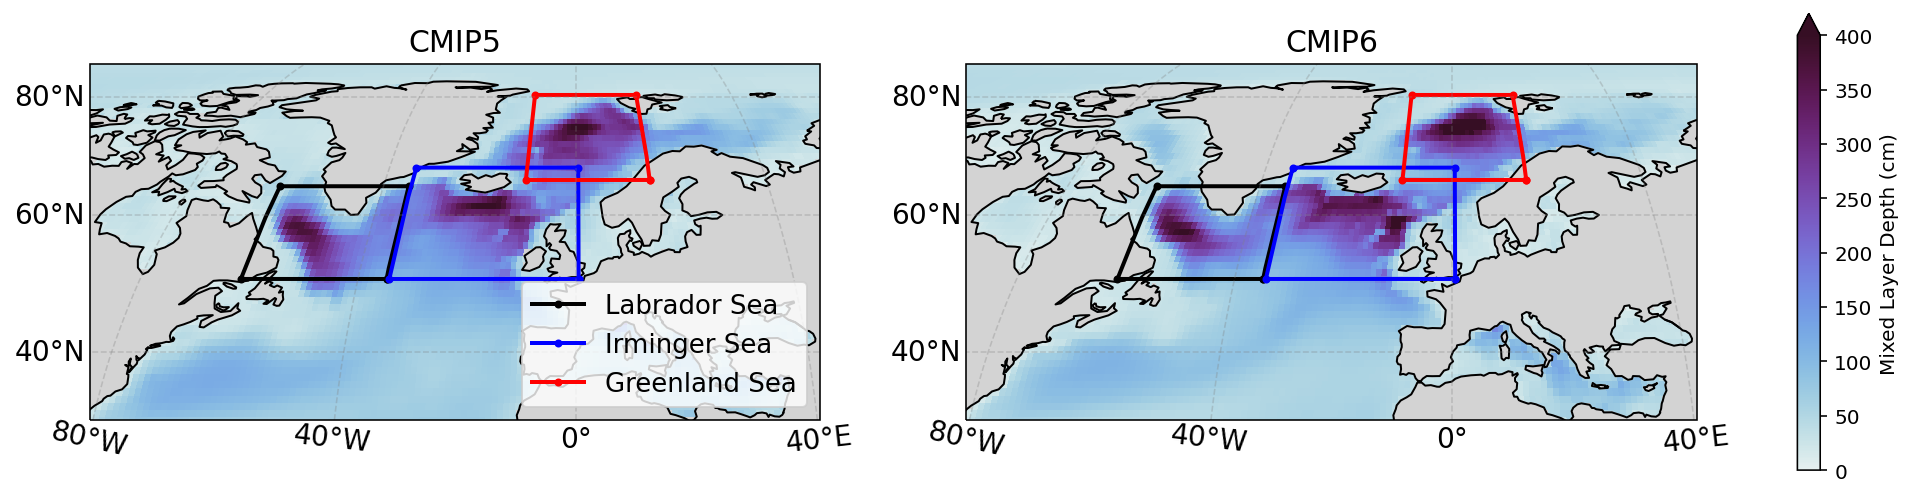

In [66]:
b5 = MLD_ds5.sel(time=np.arange(1975.5, 2004.5)).mean(dim=['time','model'])
b6 = MLD_ds6.sel(time=np.arange(1975.5, 2004.5)).mean(dim=['time','model'])
b = xr.concat([b5,b6],dim='mip').rename({'CorrectedReggrided_mlotst':'mld'})

g = b.mld.plot(
    col='mip',
    col_wrap=2,
    figsize=(18,6),
    #Projections options: PlateCarree, Mollweide, Robinson, EckertIV, EqualEarth
    subplot_kws=dict(projection=ccrs.Robinson(), facecolor="lightgray"),
    transform=ccrs.PlateCarree(),
    cmap = 'cmo.dense',
    vmin=0, vmax=400,
    cbar_kwargs={'orientation': 'vertical', 'label': 'Mixed Layer Depth (cm)', 'pad': 0.05, 'shrink':0.7},
    robust=True)

titles = ['CMIP5', 'CMIP6', 'CMIP6 minus CMIP5']
for i in range(2):
    g.axes[0,i].set_title(titles[i],fontsize=15) 
    g.axes[0,i].add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1)    
    g.axes[0,i].coastlines()
    g.axes[0,i].set_extent([-80.5, 40.5, 30.5, 89.5])
    
    
    gl = g.axes[0,i].gridlines(color='grey', draw_labels=True,linestyle='--', alpha=0.3)
    gl.xlocator = mticker.FixedLocator([-80, -40, 0, 40])
    gl.ylocator = mticker.FixedLocator([40,60,80])
    
    gl.xlabel_style = {'size': 14}
    gl.ylabel_style = {'size': 14}

    gl.ylabels_right = False
    gl.top_labels = False
    gl.right_labels = False
    
    g.axes[0,i].plot(yLS, xLS, marker='.', color = 'k', linewidth=2.0, transform=ccrs.PlateCarree(),label='Labrador Sea')
    g.axes[0,i].plot(yIS, xIS, marker='.', color = 'b', linewidth=2.0, transform=ccrs.PlateCarree(),label='Irminger Sea')
    g.axes[0,i].plot(yGS, xGS, marker='.', color = 'r', linewidth=2.0, transform=ccrs.PlateCarree(),label='Greenland Sea')
g.axes[0,0].legend(loc='lower right',fontsize=13)

plt.savefig(savepath + f"MLD_CMIP5vsCMIP6.pdf",bbox_inches='tight',transparent=True, pad_inches=0, dpi=100)

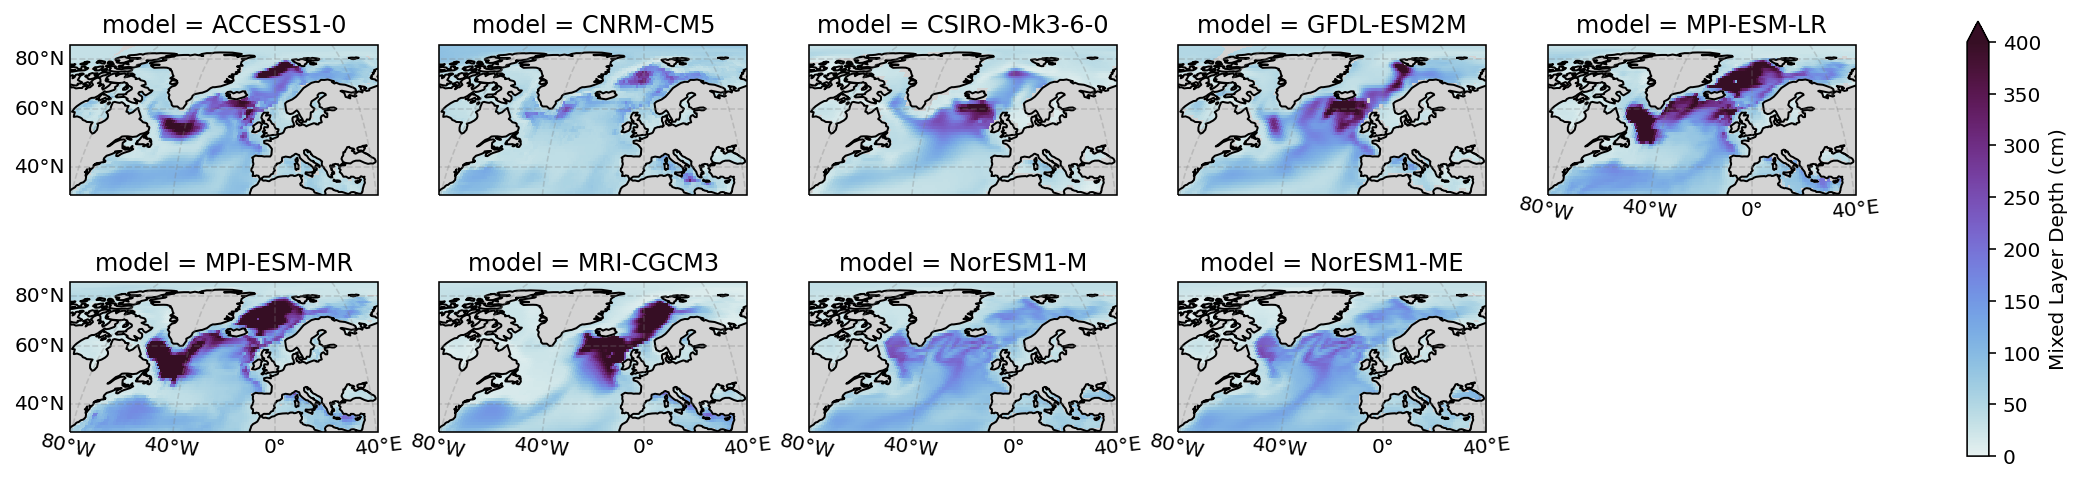

In [72]:
MLDTRY5 = MLD_ds5.sel(time=slice(1975,2005)).mean(dim='time')
ncols=5
g = MLDTRY5.CorrectedReggrided_mlotst.plot(
    col='model',
    col_wrap=ncols,
    figsize=(20,4),
    #Projections options: PlateCarree, Mollweide, Robinson, EckertIV, EqualEarth
    subplot_kws=dict(projection=ccrs.Robinson(), facecolor="lightgray"),
    transform=ccrs.PlateCarree(),
    cmap = 'cmo.dense',
    vmin=0, vmax=400,
    cbar_kwargs={'orientation': 'vertical', 'label': 'Mixed Layer Depth (cm)', 'pad': 0.05, 'shrink':1},
    robust=True)

ax = g.axes.ravel()

for i,mods in enumerate(MLDTRY5.model.values):
    ax[i].set_title(f'model = {mods}',fontsize=12) 
    ax[i].add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1)    
    ax[i].coastlines()
    ax[i].set_extent([-80.5, 40.5, 30.5, 89.5])
    
    
    gl = ax[i].gridlines(color='grey', draw_labels=True,linestyle='--', alpha=0.3)
    gl.xlocator = mticker.FixedLocator([-80, -40, 0, 40])
    gl.ylocator = mticker.FixedLocator([40,60,80])
    
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}

    gl.ylabels_right = False
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = False
    
    if i < (len(MLDTRY5.model.values)-ncols):
        gl.bottom_labels = False
    if i % ncols == 0:            
        gl.left_labels = True
        
plt.savefig(savepath + f"MLD_Single_CMIP5.png",bbox_inches='tight',transparent=True, pad_inches=0, dpi=200)

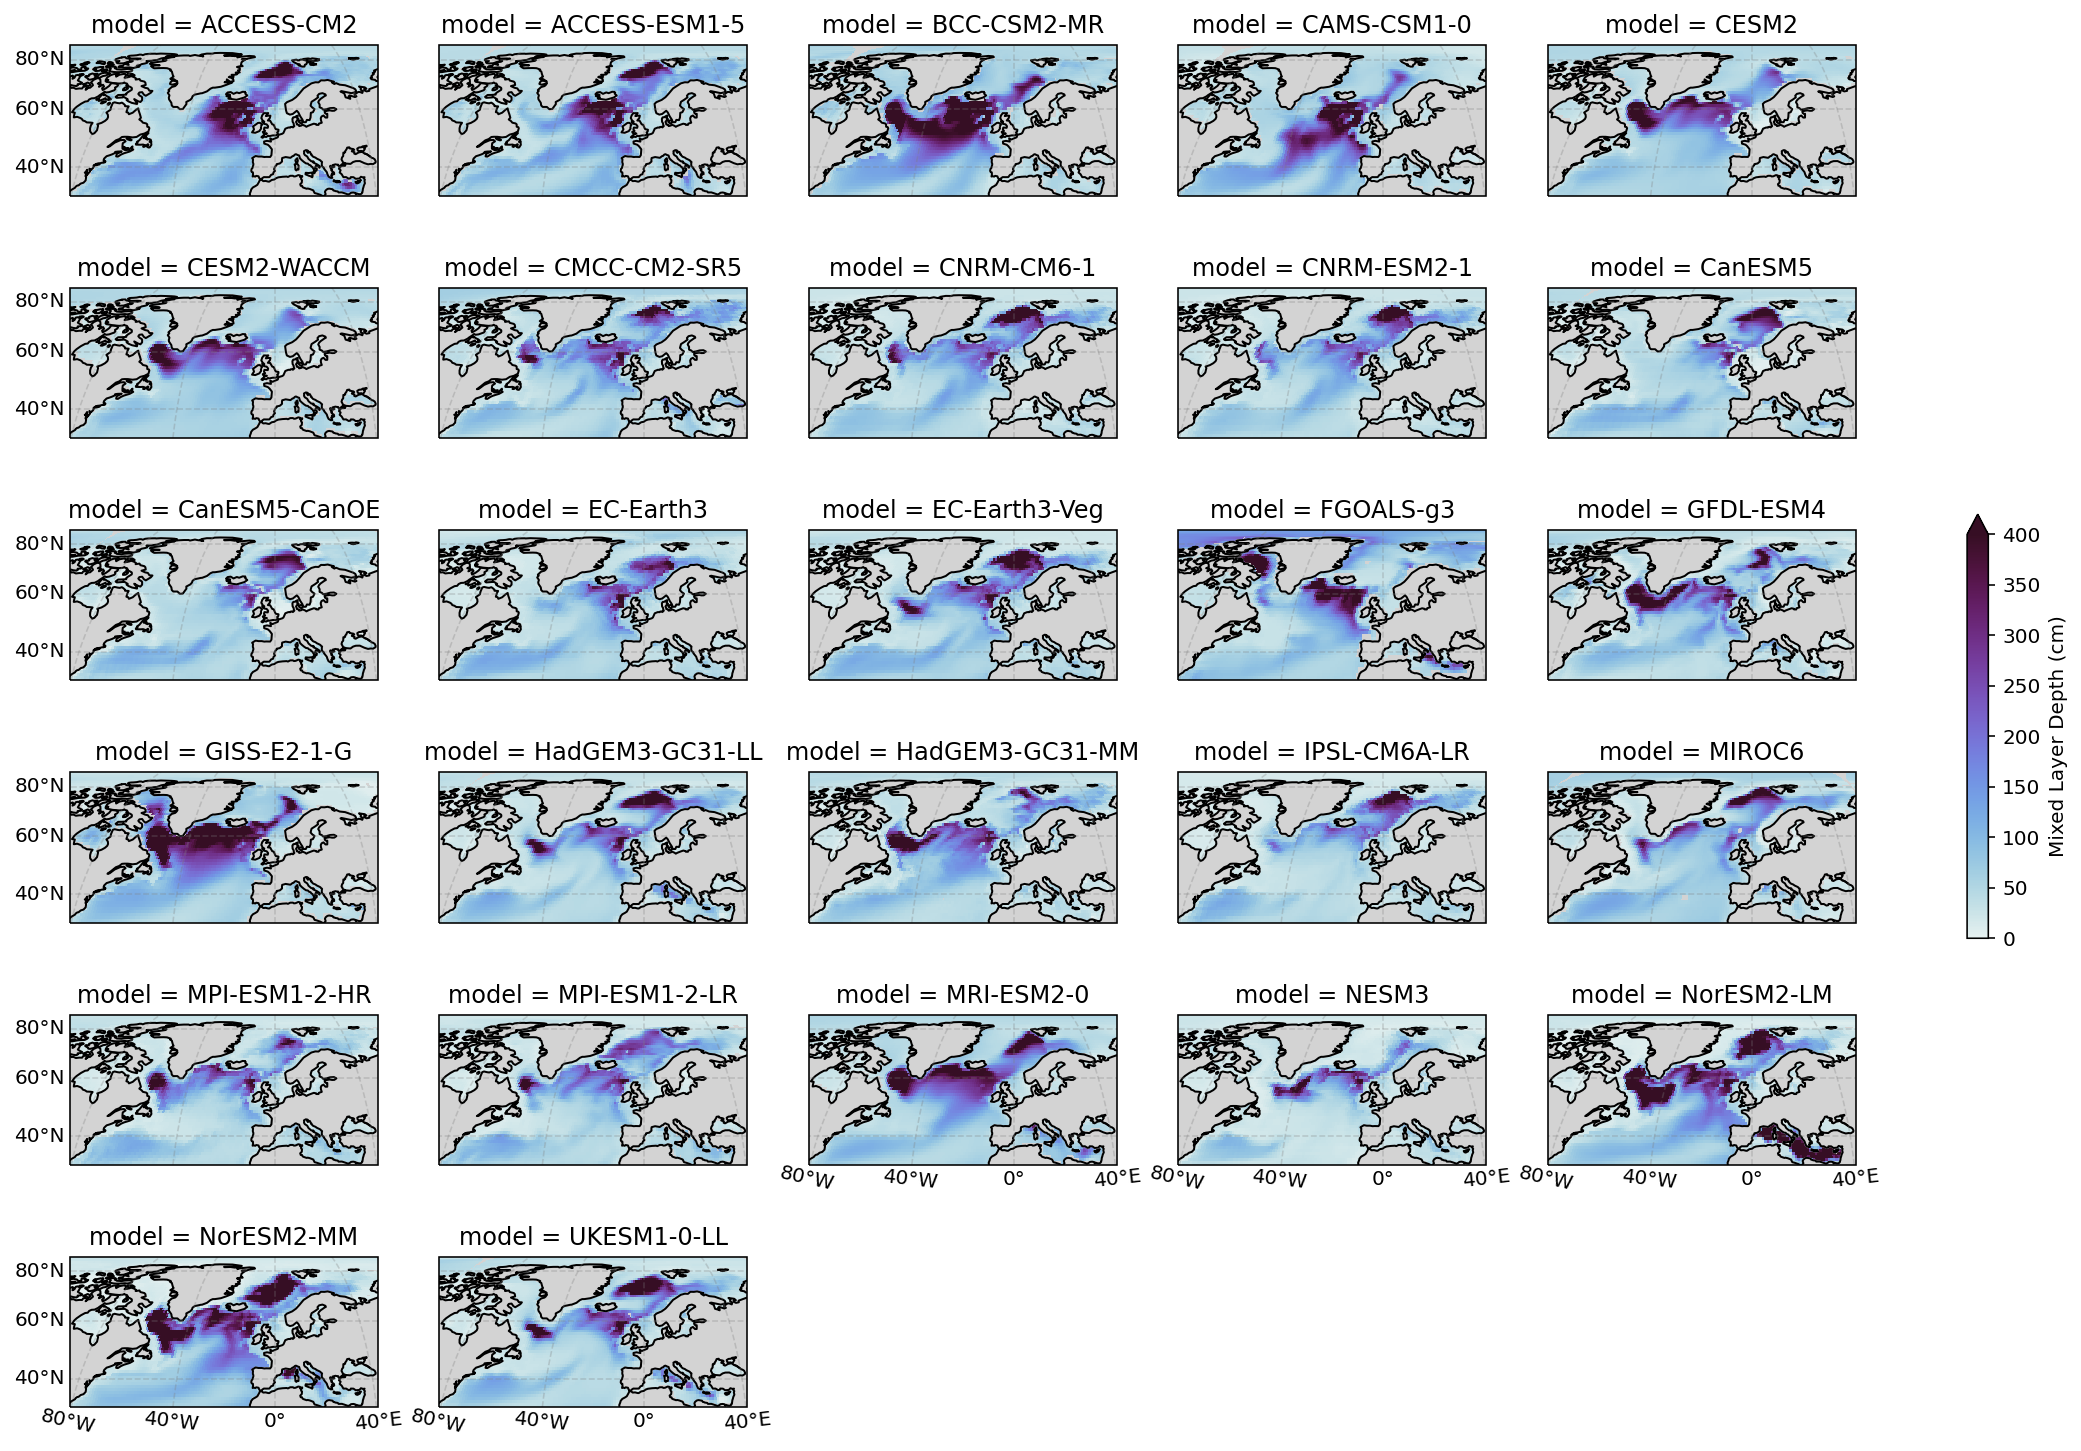

In [73]:
MLDTRY6 = MLD_ds6.sel(time=slice(1975,2005)).mean(dim='time')
ncols = 5
g = MLDTRY6.CorrectedReggrided_mlotst.plot(
    col='model',
    col_wrap=ncols,
    figsize=(20,13),
    #Projections options: PlateCarree, Mollweide, Robinson, EckertIV, EqualEarth
    subplot_kws=dict(projection=ccrs.Robinson(), facecolor="lightgray"),
    transform=ccrs.PlateCarree(),
    cmap = 'cmo.dense',
    vmin=0, vmax=400,
    cbar_kwargs={'orientation': 'vertical', 'label': 'Mixed Layer Depth (cm)', 'pad': 0.05, 'shrink':0.3},
    robust=True)

ax = g.axes.ravel()

for i,mods in enumerate(MLDTRY6.model.values):
    ax[i].set_title(f'model = {mods}',fontsize=12) 
    ax[i].add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1)    
    ax[i].coastlines()
    ax[i].set_extent([-80.5, 40.5, 30.5, 89.5])
    
    
    gl = ax[i].gridlines(color='grey', draw_labels=True,linestyle='--', alpha=0.3)
    gl.xlocator = mticker.FixedLocator([-80, -40, 0, 40])
    gl.ylocator = mticker.FixedLocator([40,60,80])
    
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}

    gl.ylabels_right = False
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = False 
    if i < (len(MLDTRY6.model.values)-ncols):
        gl.bottom_labels = False
    if i % ncols == 0:            
        gl.left_labels = True
        
plt.savefig(savepath + f"MLD_Single_CMIP6.png",bbox_inches='tight',transparent=True, pad_inches=0, dpi=100)

In [58]:
## Identify regions with MLD in CMIP5 and CMIP6 available models:

In [12]:
# Calculate mean MLD for each model in the three different regions for a certain period
def mean_MLD(ds, region, start_year, end_year):
    
    if region == 'LS':
        lats = np.arange(50.5,64.5)
        lons = np.arange(-61.5,-34.5)
    elif region == 'IS':
        lats = np.arange(50.5,67.5)
        lons = np.arange(-34.5,0.5)
    elif region == 'GS':
        lats = np.arange(65.5,80.5)
        lons = np.arange(-10.5,15.5)
    else:
        print('Region is not recognized, choose \'LS\', \'IS\' or \'GS\'')
    
    region_MLD = ds.sel(lat=lats,lon=lons,time=np.arange(start_year+.5,end_year+.5))
    region_MLD_mean = region_MLD.mean(dim=['time','lon','lat']).CorrectedReggrided_mlotst
    region_MLD_max = np.max(region_MLD.mean(dim='time').CorrectedReggrided_mlotst.values)
    return region_MLD_mean, region_MLD_max

In [13]:
start_yr, end_yr = 1975,2005

dfs,max_dfs = [],[]
for ds in [MLD_ds5, MLD_ds6]:
    mean_MLD_LS,max_MLD_LS = mean_MLD(ds, 'LS', start_yr, end_yr)
    mean_MLD_IS,max_MLD_IS = mean_MLD(ds, 'IS', start_yr, end_yr)
    mean_MLD_GS,max_MLD_GS = mean_MLD(ds, 'GS', start_yr, end_yr)

    mean_MLD_tot = (mean_MLD_LS + mean_MLD_IS + mean_MLD_GS)
    
    # Construct dataframe
    d = {'model': mean_MLD_LS.model.values, 'MLD_LS':mean_MLD_LS.values,'MLD_IS':mean_MLD_IS.values,'MLD_GS':mean_MLD_GS.values }
    df = pd.DataFrame(data=d)
    dfnew = df.set_index('model')
    
    dfs.append(dfnew)
    
    d = {'model': mean_MLD_LS.model.values, 'MLD_LS':max_MLD_LS,'MLD_IS':max_MLD_IS,'MLD_GS':max_MLD_GS }
    max_df = pd.DataFrame(data=d)
    max_dfnew = df.set_index('model')
    
    max_dfs.append(max_dfnew)

In [26]:
max_dfs[0].index

Index(['GFDL-ESM2M', 'ACCESS1-0', 'MPI-ESM-LR', 'MRI-CGCM3', 'CNRM-CM5',
       'NorESM1-M', 'NorESM1-ME', 'GFDL-CM3', 'MPI-ESM-MR', 'CSIRO-Mk3-6-0'],
      dtype='object', name='model')

In [25]:
max_dfs[1].index

Index(['MRI-ESM2-0', 'FGOALS-g3', 'CNRM-CM6-1', 'HadGEM3-GC31-MM',
       'BCC-CSM2-MR', 'CESM2-WACCM', 'EC-Earth3', 'ACCESS-ESM1-5',
       'GISS-E2-1-G', 'MPI-ESM1-2-LR', 'HadGEM3-GC31-LL', 'IPSL-CM6A-LR',
       'GFDL-ESM4', 'CanESM5', 'MIROC6', 'NorESM2-MM', 'CESM2', 'NESM3',
       'NorESM2-LM', 'CNRM-ESM2-1', 'CAMS-CSM1-0', 'CMCC-CM2-SR5',
       'ACCESS-CM2', 'MPI-ESM1-2-HR', 'UKESM1-0-LL', 'CanESM5-CanOE',
       'EC-Earth3-Veg'],
      dtype='object', name='model')

In [18]:
CMIP5_MLD = max_dfs[0]
CMIP6_MLD = max_dfs[1]

MLD_th = 170

# select models for convection per ocean
Conv_LS = CMIP5_MLD[CMIP5_MLD['MLD_LS'] > MLD_th]
Conv_IS = CMIP5_MLD[CMIP5_MLD['MLD_IS'] > MLD_th]
Conv_GS = CMIP5_MLD[CMIP5_MLD['MLD_GS'] > MLD_th]

mods5_LS = Conv_LS.index
mods5_IS = Conv_IS.index
mods5_GS = Conv_GS.index


# select models for convection per ocean
Conv_LS = CMIP6_MLD[CMIP6_MLD['MLD_LS'] > MLD_th]
Conv_IS = CMIP6_MLD[CMIP6_MLD['MLD_IS'] > MLD_th]
Conv_GS = CMIP6_MLD[CMIP6_MLD['MLD_GS'] > MLD_th]

mods6_LS = Conv_LS.index
mods6_IS = Conv_IS.index
mods6_GS = Conv_GS.index

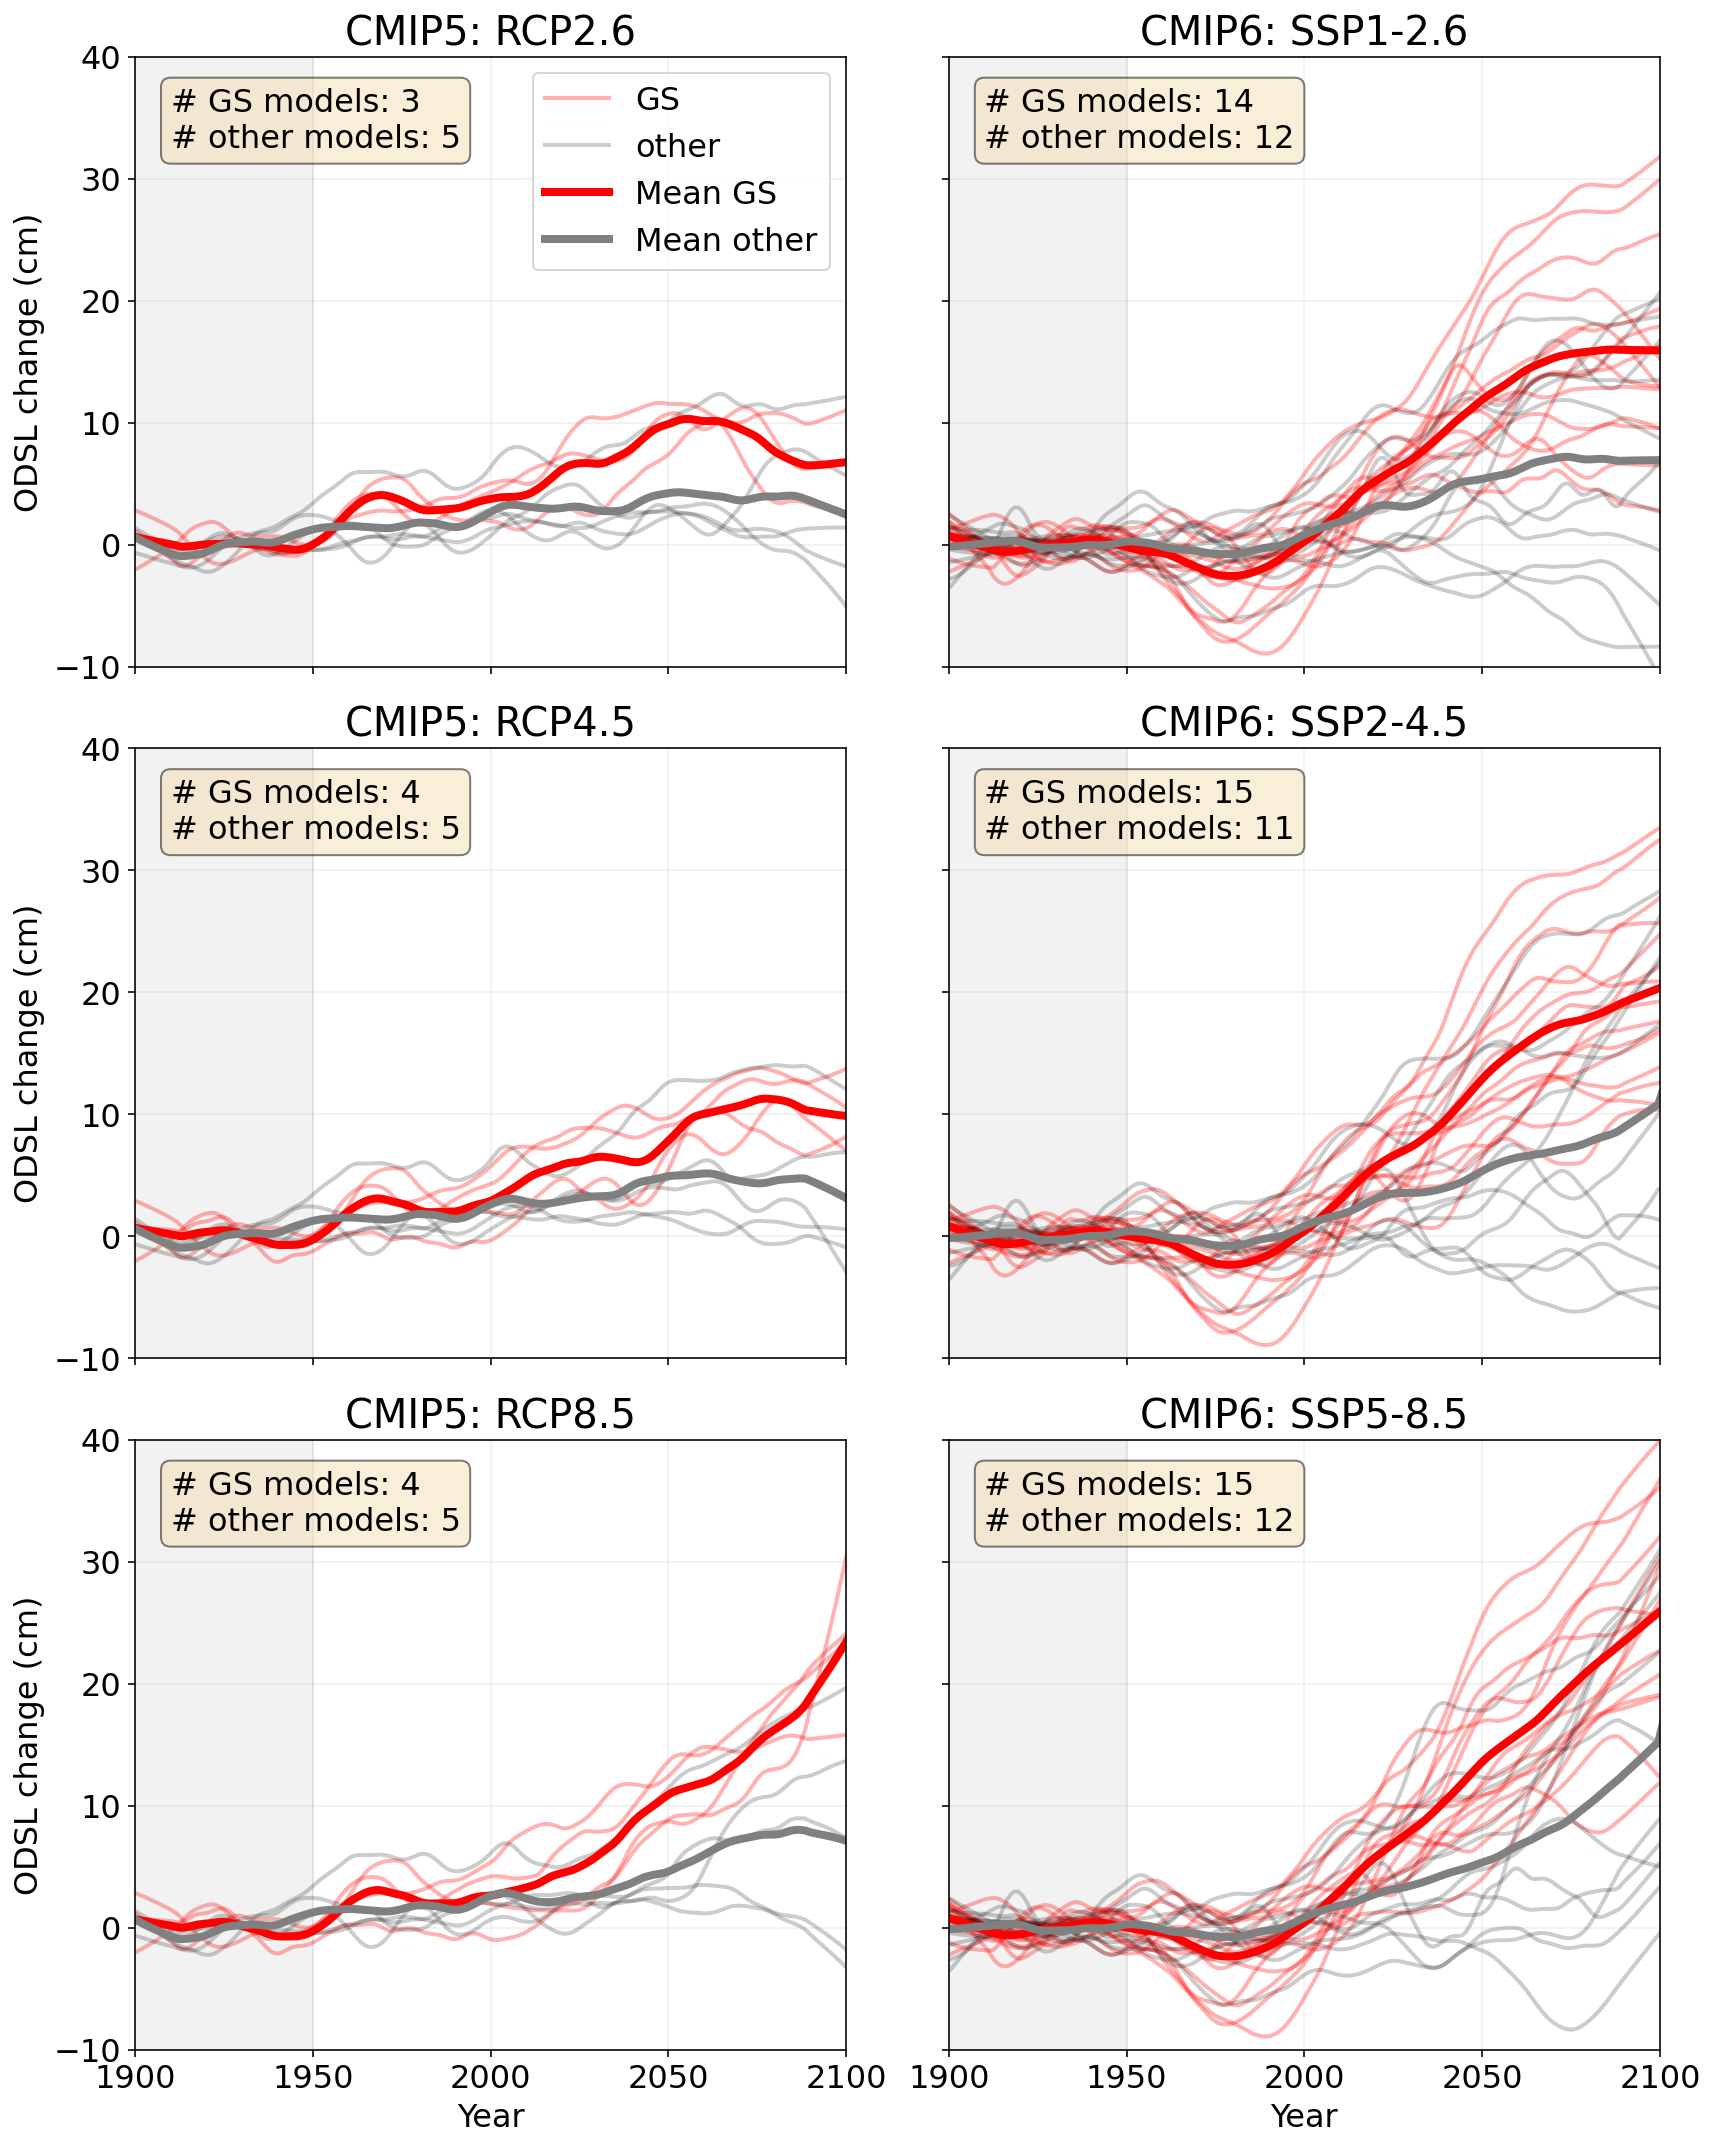

In [24]:
fig, ax = plt.subplots(3,2, figsize=(12,15),sharey=True,sharex=True)
m5_sces = ['RCP2.6', 'RCP4.5', 'RCP8.5']
m6_sces = ['SSP1-2.6', 'SSP2-4.5', 'SSP5-8.5']

for i, sces in enumerate(['ssp126','ssp245','ssp585']):

    CMIP5ds_LF_zos = select_models(CMIP5ds_LF.sel(scenario=sces), 'zos', 'GSAT', 'zos', 'model')[1]
    CMIP6ds_LF_zos = select_models(CMIP6ds_LF.sel(scenario=sces), 'zos', 'GSAT', 'zos', 'model')[1]

    mods_MLD_zos5 = list(set(CMIP5ds_LF_zos.model.values)&set(CMIP5_MLD.index))
    mods_MLD_zos6 = list(set(CMIP6ds_LF_zos.model.values)&set(CMIP6_MLD.index))

    CMIP5ds_LF_zos = CMIP5ds_LF_zos.sel(model=mods_MLD_zos5)
    CMIP6ds_LF_zos = CMIP6ds_LF_zos.sel(model=mods_MLD_zos6)

    mods5_GS_sce = list(set(CMIP5ds_LF_zos.model.values)&set(mods5_GS))
    mods6_GS_sce = list(set(CMIP6ds_LF_zos.model.values)&set(mods6_GS))

    set_GS5 = CMIP5ds_LF_zos.sel(model=mods5_GS_sce).zos
    set_GS6 = CMIP6ds_LF_zos.sel(model=mods6_GS_sce).zos
    
    mean_GS5 = set_GS5.mean(dim='model').values
    mean_GS6 = set_GS6.mean(dim='model').values
    std_GS5 = set_GS5.std(dim='model').values
    std_GS6 = set_GS6.std(dim='model').values

    mods5_other = list(set(CMIP5ds_LF_zos.model.values).difference(mods5_GS_sce))
    mods6_other = list(set(CMIP6ds_LF_zos.model.values).difference(mods6_GS_sce))  
    
    set_other5 = CMIP5ds_LF_zos.sel(model=mods5_other).zos
    set_other6 = CMIP6ds_LF_zos.sel(model=mods6_other).zos
    mean_other5 = set_other5.mean(dim='model').values
    mean_other6 = set_other6.mean(dim='model').values
    std_other5 = set_other5.std(dim='model').values
    std_other6 = set_other6.std(dim='model').values
    
    time5 = CMIP5ds_LF_zos.time.values
    time6 = CMIP6ds_LF_zos.time.values

    # Plot individual models
    ax[i,0].plot(time5, set_GS5.values[0].T, 'r',lw=2, alpha=0.3, label='GS')
    ax[i,0].plot(time5, set_GS5.values[1:].T, 'r', lw=2,alpha=0.3)

    ax[i,0].plot(time5, set_other5.values[0].T, 'k',lw=2, alpha=0.2, label='other')
    ax[i,0].plot(time5, set_other5.values[1:].T, 'k',lw=2, alpha=0.2)

    ax[i,1].plot(time6, set_GS6.values.T, 'r', lw=2, alpha=0.3)
    ax[i,1].plot(time6, set_other6.values.T, 'k', lw=2, alpha=0.2)
    
     # Plot median
    ax[i,0].plot(time5, set_GS5.mean(dim='model').values, 'r',lw=4, label='Mean GS')
    ax[i,0].plot(time5, set_other5.mean(dim='model').values, 'grey',lw=4, label='Mean other')
    ax[i,1].plot(time6, set_GS6.mean(dim='model').values, 'r',lw=4)
    ax[i,1].plot(time6, set_other6.mean(dim='model').values, 'grey',lw=4)

    ax[i,0].set_ylabel('ODSL change (cm)',fontsize=16)
    ax[i,0].set_title(f'CMIP5: {m5_sces[i]}',fontsize=20)
    ax[i,1].set_title(f'CMIP6: {m6_sces[i]}',fontsize=20)

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    textstr5 = f'# GS models: {len(set_GS5.model.values)} \n# other models: {len(set_other5.model.values)}'
    textstr6 = f'# GS models: {len(set_GS6.model.values)} \n# other models: {len(set_other6.model.values)}'

    ax[i,0].text(0.05, 0.95, textstr5, transform=ax[i,0].transAxes, fontsize=16, verticalalignment='top', bbox=props)
    ax[i,1].text(0.05, 0.95, textstr6, transform=ax[i,1].transAxes, fontsize=16, verticalalignment='top', bbox=props)


    # Print text box with # of models for GS and Other
    
for axs in ax.flatten():
    axs.set_ylim([-10,40])
    axs.set_xlim([1900,2100])
    axs.tick_params(labelsize=16)
    axs.grid(True,alpha=.2)
    axs.axvspan(1900, 1950, alpha=0.1, color='grey')

ax[0,0].legend(loc='upper right',fontsize=16)
ax[2,0].set_xlabel('Year',fontsize=16)
ax[2,1].set_xlabel('Year',fontsize=16)

fig.tight_layout()
fig.savefig(savepath+f'MLD_scenarios_Median_allMLDmodels.pdf',dpi=dpi)

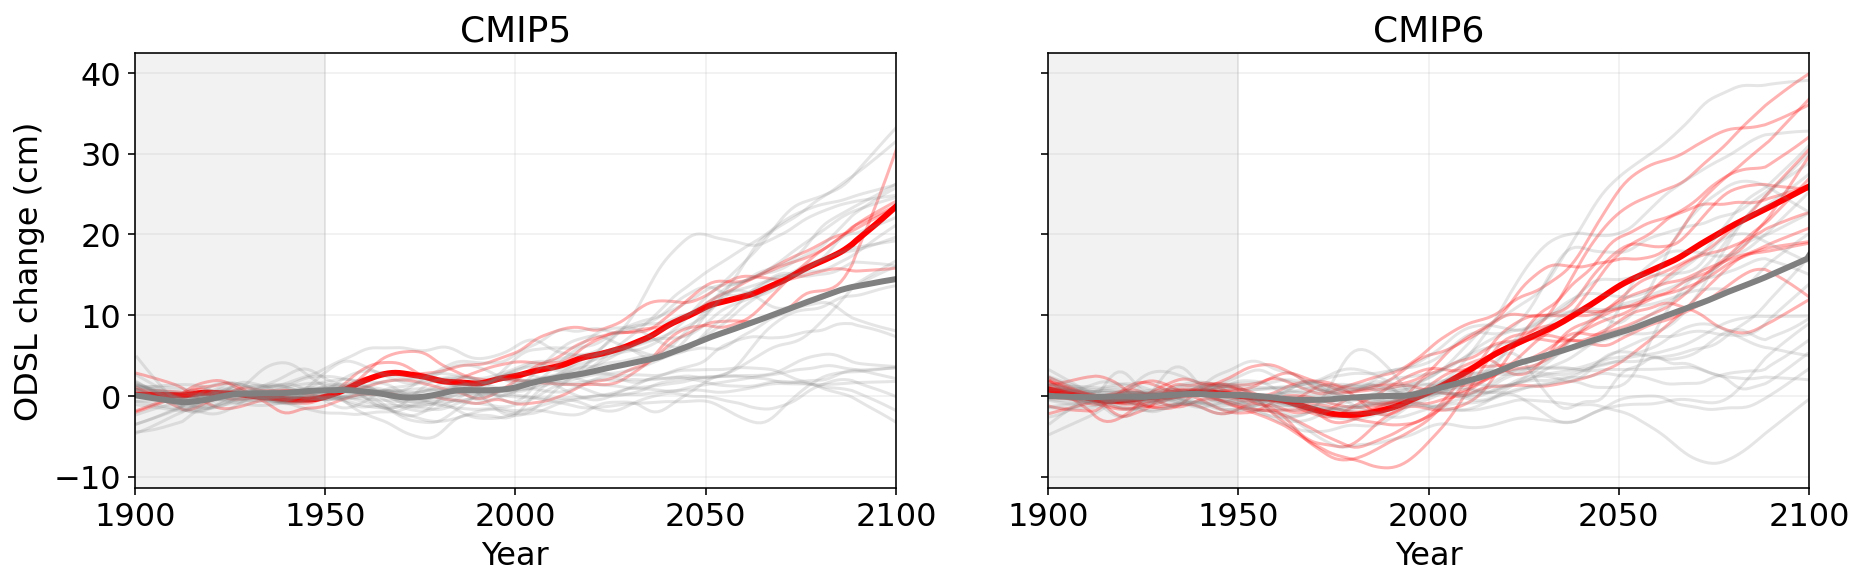

In [20]:
scess = 'ssp585'
fig, ax = plt.subplots(1,2,figsize=(15,4),sharey=True)

time = CMIP5ds_LF.time.values
mods_int = list(set(mods5_GS)&set(CMIP5ds_LF.model.values))
mods_left = list(set(CMIP5ds_LF.model.values).difference(mods_int))

for i in range(len(mods5_GS)):
    ax[0].plot(time,CMIP5ds_LF.sel(scenario=scess,model=mods5_GS).zos.values[i], c='r',alpha=0.3)
ax[0].plot(time,CMIP5ds_LF.sel(scenario=scess,model=mods5_GS).mean(dim='model').zos.values,c='r',lw=3)

for i in range(len(mods_left)):
    ax[0].plot(time,CMIP5ds_LF.sel(scenario=scess,model=mods_left).zos.values[i],color='grey',alpha=0.2)
ax[0].plot(time,CMIP5ds_LF.sel(scenario=scess,model=mods_left).mean(dim='model').zos.values,c='grey',lw=3)
ax[0].set_title('CMIP5',fontsize=18)
ax[0].set_ylabel('ODSL change (cm)',fontsize=16)
mods_int = list(set(mods6_GS)&set(CMIP6ds_LF.model.values))
mods_left = list(set(CMIP6ds_LF.model.values).difference(mods_int))

for i in range(len(mods_int)):
    ax[1].plot(time,CMIP6ds_LF.sel(scenario=scess,model=mods_int).zos.values[i], c='r',alpha=0.3)
ax[1].plot(time,CMIP6ds_LF.sel(scenario=scess,model=mods_int).mean(dim='model').zos.values,c='r',lw=3)

for i in range(len(mods_left)):
    ax[1].plot(time,CMIP6ds_LF.sel(scenario=scess,model=mods_left).zos.values[i],color='grey',alpha=0.2)
ax[1].plot(time,CMIP6ds_LF.sel(scenario=scess,model=mods_left).mean(dim='model').zos.values,c='grey',lw=3)
ax[1].set_title('CMIP6',fontsize=18)

for axs in ax:
    axs.set_xlim([1900,2100])
    axs.tick_params(labelsize=16)
    axs.grid(True,alpha=.2)
    axs.set_xlabel('Year',fontsize=16)
    axs.axvspan(1900, 1950, alpha=0.1, color='grey')


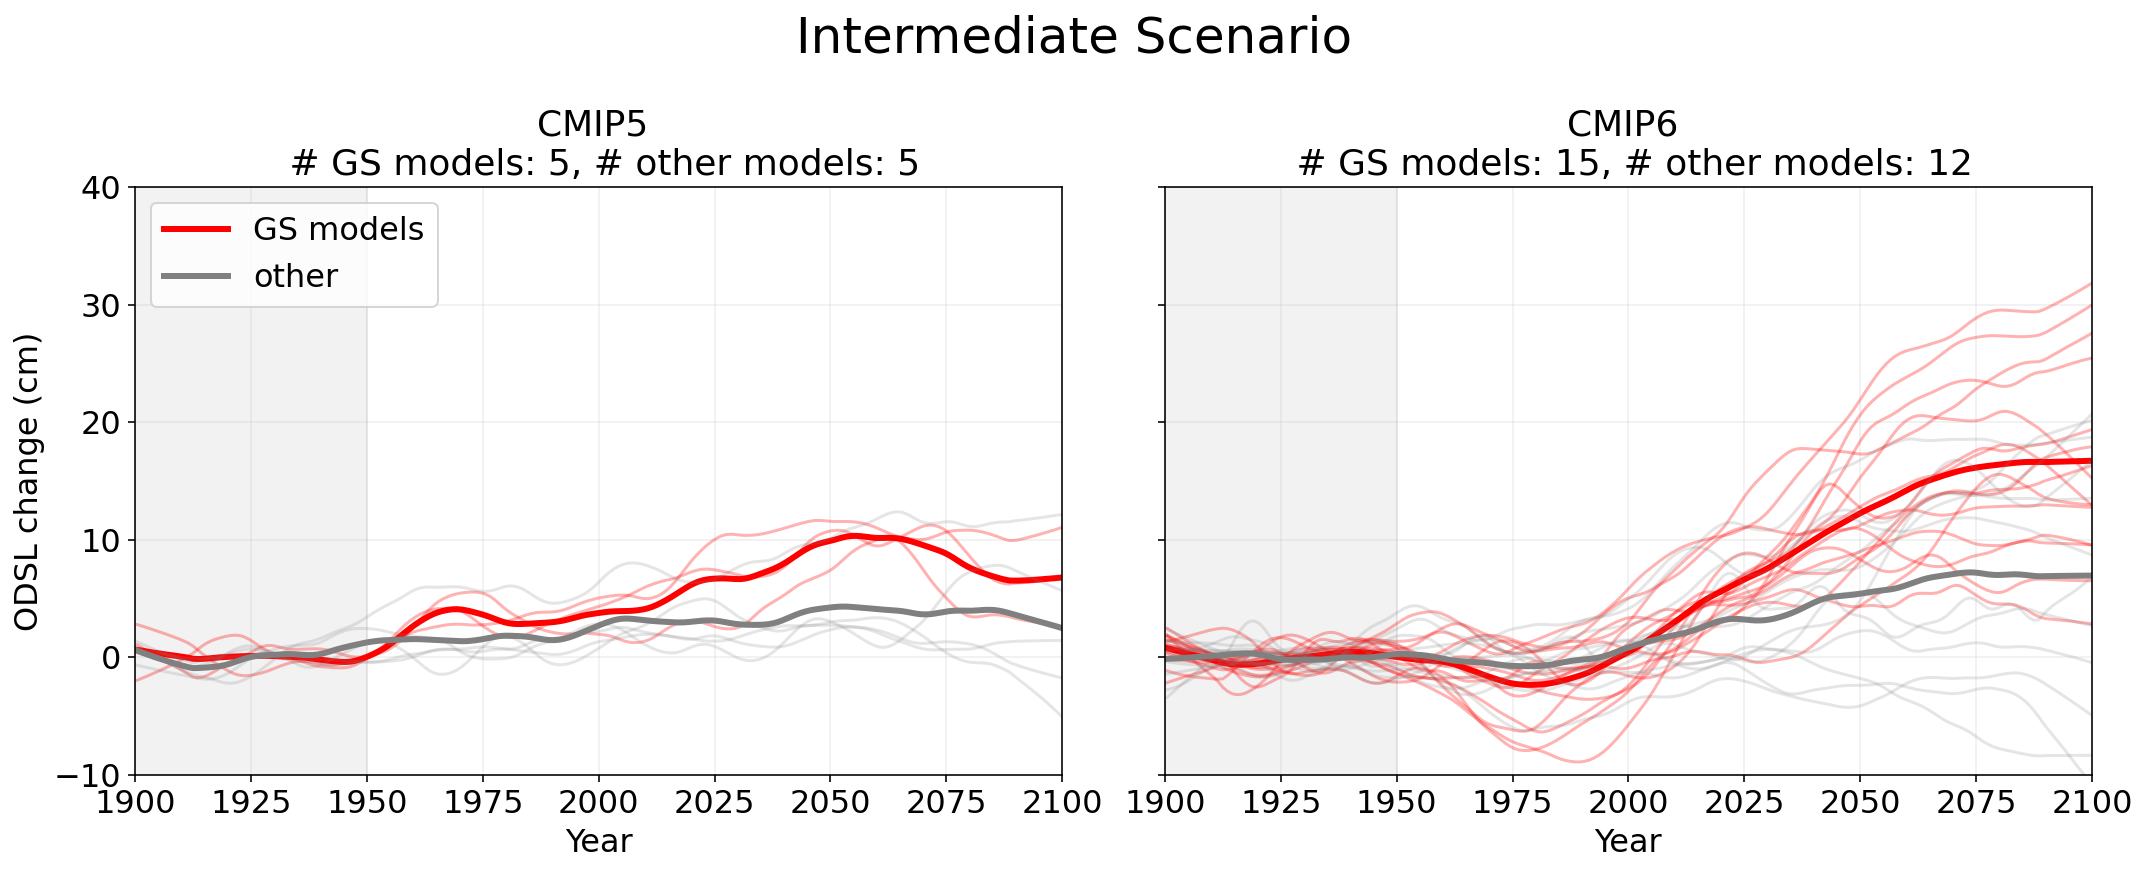

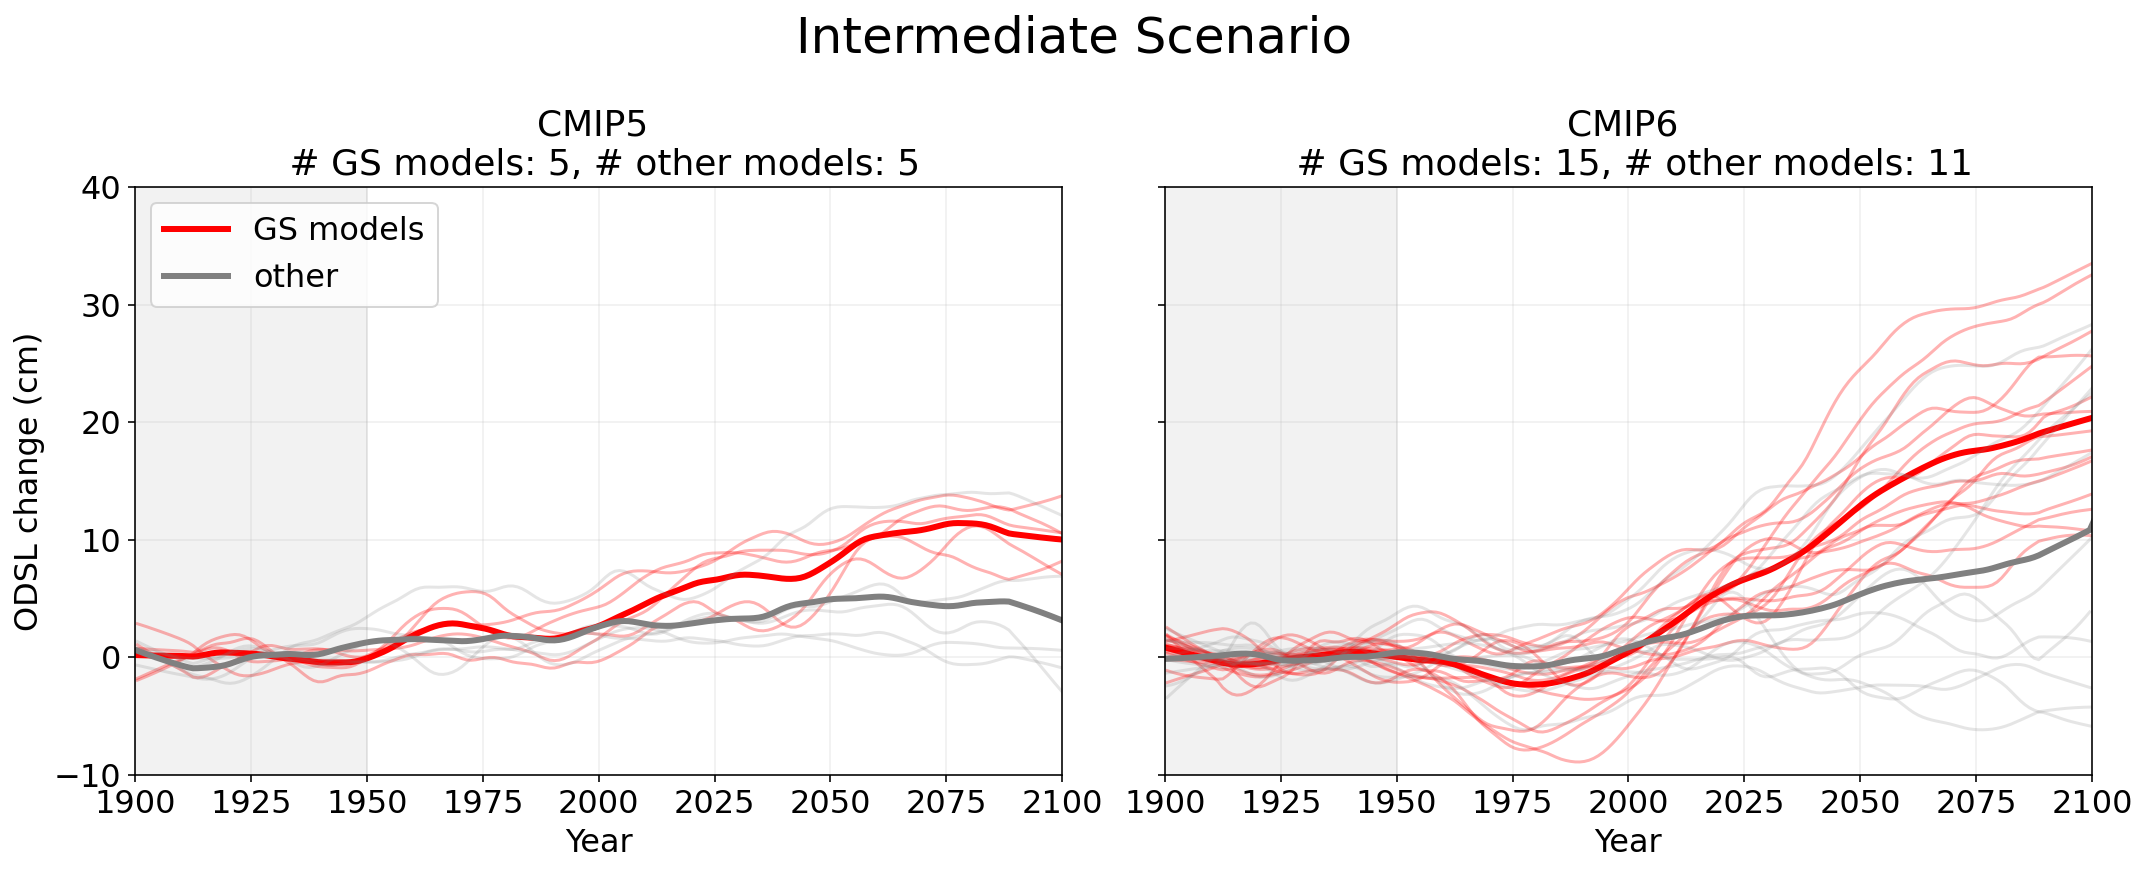

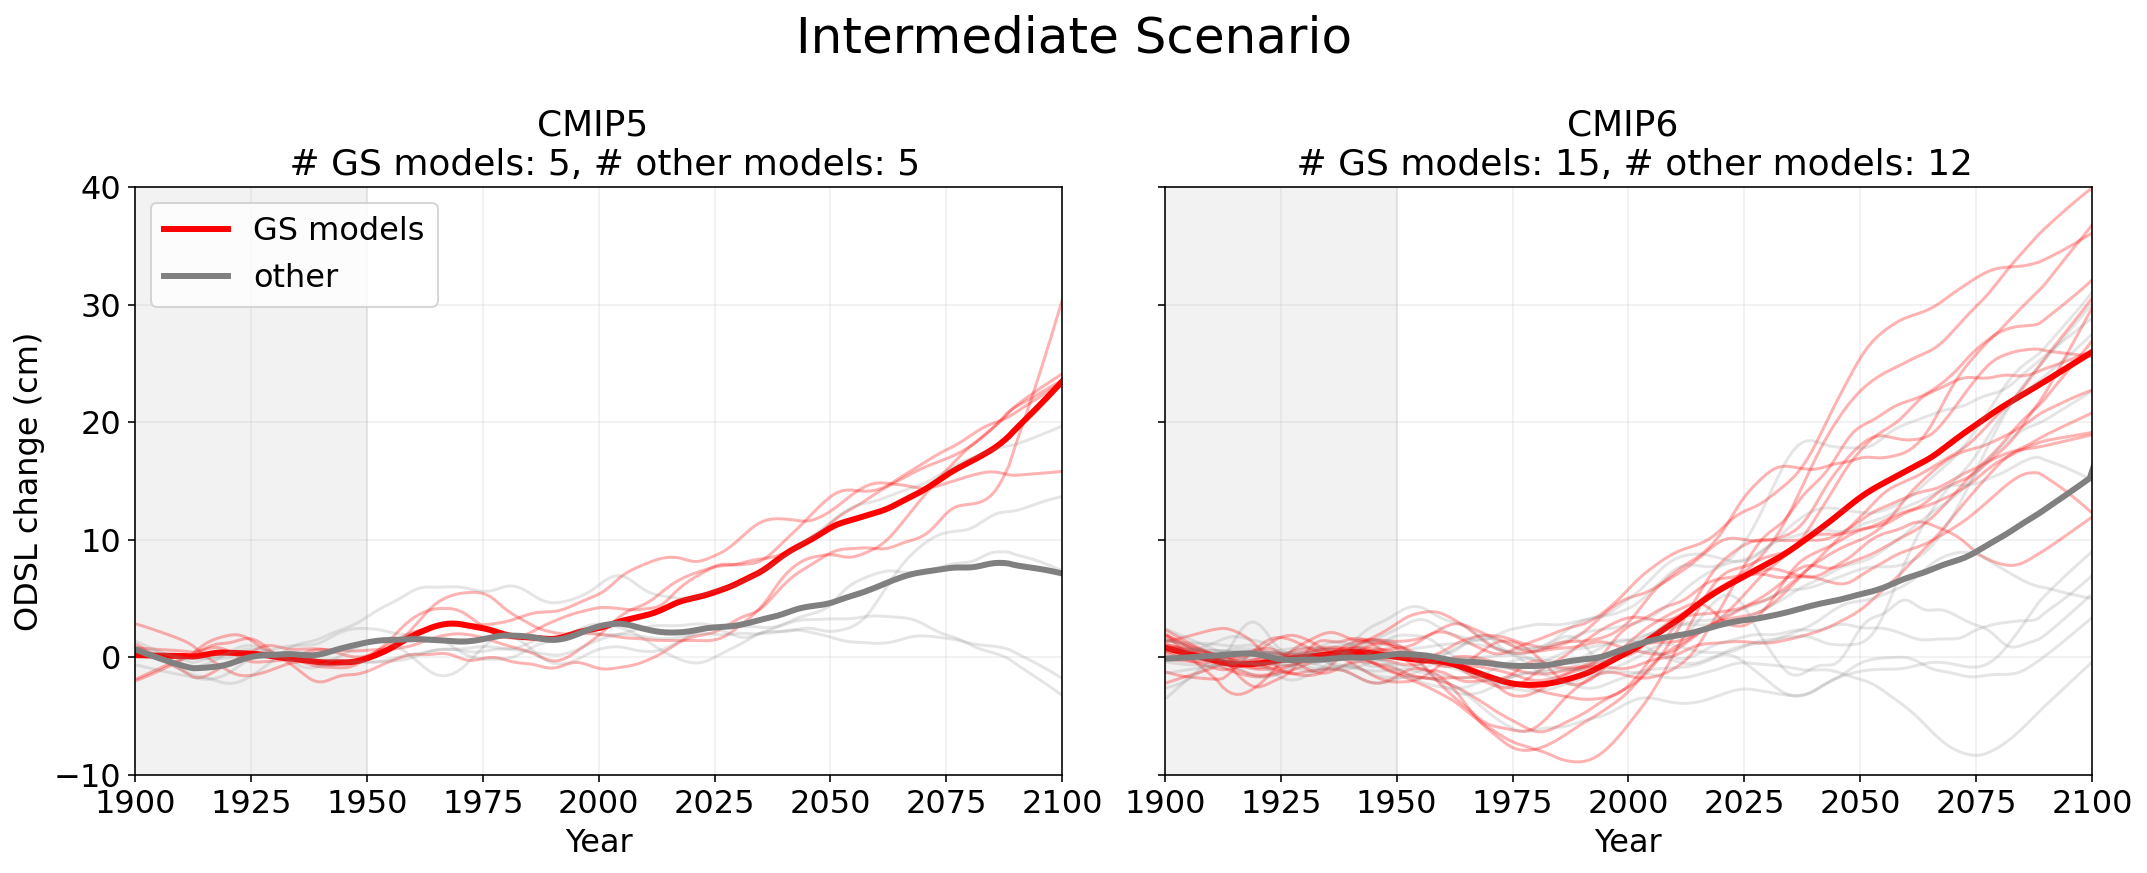

In [134]:
mods_int5, mods_int6 = [],[]
mods_left5, mods_left6 = [],[]

for sce in ['ssp126','ssp245','ssp585']:
    
    fig, ax = plt.subplots(1,2,figsize=(15,6),sharey=True)
    fig.suptitle(f'Intermediate Scenario',fontsize=25,y=1)
    
    CMIP5_zosmods = CMIP5ds_LF.sel(scenario=sce)['zos'].dropna('model','all')['model'].values 
    CMIP5_zos_ds = CMIP5ds_LF.sel(model=CMIP5_zosmods)
    
    time = CMIP5_zos_ds.time.values
   
    mods_int = list(set(mods5_GS)&set(CMIP5_zos_ds.model.values))
    mods_left = list(set(CMIP5_zos_ds.model.values).difference(mods_int)&set(MLD_ds5.model.values))
    
    mods_int5.append(mods_int)
    mods_left5.append(mods_left)
    
    for i in range(len(mods_int)):
        ax[0].plot(time,CMIP5_zos_ds.sel(scenario=sce,model=mods_int).zos.values[i], c='r',alpha=0.3)
    ax[0].plot(time,CMIP5_zos_ds.sel(scenario=sce,model=mods_int).mean(dim='model').zos.values,c='r',lw=3, label='GS models')
    
    for i in range(len(mods_left)):
        ax[0].plot(time,CMIP5_zos_ds.sel(scenario=sce,model=mods_left).zos.values[i],color='grey',alpha=0.2)
    ax[0].plot(time,CMIP5_zos_ds.sel(scenario=sce,model=mods_left).mean(dim='model').zos.values,c='grey',lw=3, label='other')
    ax[0].set_title(f'CMIP5 \n # GS models: {len(mods5_GS)}, # other models: {len(mods_left)}',fontsize=18)
    ax[0].set_ylabel('ODSL change (cm)',fontsize=16)
    
    
    CMIP6_zosmods = CMIP6ds_LF.sel(scenario=sce)['zos'].dropna('model','all')['model'].values 
    CMIP6_zos_ds = CMIP6ds_LF.sel(model=CMIP6_zosmods)
    
    time = CMIP6_zos_ds.time.values
   
    mods_int = list(set(mods6_GS)&set(CMIP6_zos_ds.model.values))
    mods_left = list(set(CMIP6_zos_ds.model.values).difference(mods_int)&set(MLD_ds6.model.values))
    
    mods_int6.append(mods_int)
    mods_left6.append(mods_left)
    
    for i in range(len(mods_int)):
        ax[1].plot(time,CMIP6_zos_ds.sel(scenario=sce,model=mods_int).zos.values[i], c='r',alpha=0.3)
    ax[1].plot(time,CMIP6_zos_ds.sel(scenario=sce,model=mods_int).mean(dim='model').zos.values,c='r',lw=3)
    
    for i in range(len(mods_left)):
        ax[1].plot(time,CMIP6_zos_ds.sel(scenario=sce,model=mods_left).zos.values[i],color='grey',alpha=0.2)
    ax[1].plot(time,CMIP6_zos_ds.sel(scenario=sce,model=mods_left).mean(dim='model').zos.values,c='grey',lw=3)
    ax[1].set_title(f'CMIP6 \n # GS models: {len(mods_int)}, # other models: {len(mods_left)}',fontsize=18)
    ax[0].legend(loc='upper left',fontsize=16)
    for axs in ax:
        axs.set_ylim([-10,40])
        axs.set_xlim([1900,2100])
        axs.tick_params(labelsize=16)
        axs.grid(True,alpha=.2)
        axs.set_xlabel('Year',fontsize=16)
        axs.axvspan(1900, 1950, alpha=0.1, color='grey')
    fig.tight_layout()
    fig.savefig(savepath+f'MLD_{sce}_time.png',dpi=200)

In [50]:
GS5 = make_barplot(CMIP5ds_LF, 'cmip5', mods_int5, [5,17,50,83,95], 2081, 2100)
GS6 = make_barplot(CMIP6ds_LF, 'cmip6', mods_int6, [5,17,50,83,95], 2081, 2100)

left5 = make_barplot(CMIP5ds_LF, 'cmip5', mods_left5, [5,17,50,83,95], 2081, 2100)
left6 = make_barplot(CMIP6ds_LF, 'cmip6', mods_left6, [5,17,50,83,95], 2081, 2100)

NameError: name 'make_barplot' is not defined

In [91]:
GS5.columns

Index(['RCP2.6', 'RCP4.5', 'RCP8.5'], dtype='object', name='CMIP5 Scenario')

In [93]:
GS5 = GS5.rename(columns = {"RCP2.6": "RCP2.6-GS", "RCP4.5": "RCP4.5-GS", "RCP8.5":'RCP8.5-GS'})
GS6 = GS6.rename(columns = {"SSP1-2.6": "SSP1-2.6-GS", "SSP2-4.5": "SSP2-4.5-GS", "SSP5-8.5":'SSP5-8.5-GS'})


In [96]:
Bar_ds5 = pd.concat([GS5, left5], axis=1)
Bar_ds6 = pd.concat([GS6, left6], axis=1)

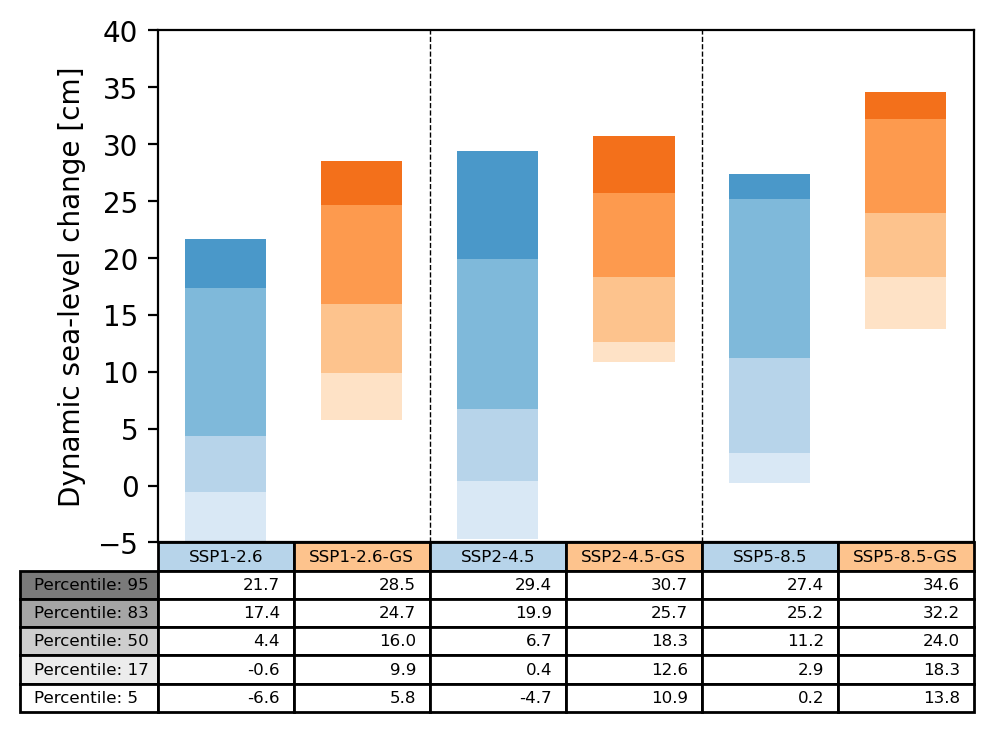

In [102]:
plot_barplots(Bar_ds6, ["SSP1-2.6","SSP1-2.6-GS", "SSP2-4.5","SSP2-4.5-GS", "SSP5-8.5",'SSP5-8.5-GS'] , 'MLD', 'MLD', saveplots=None)

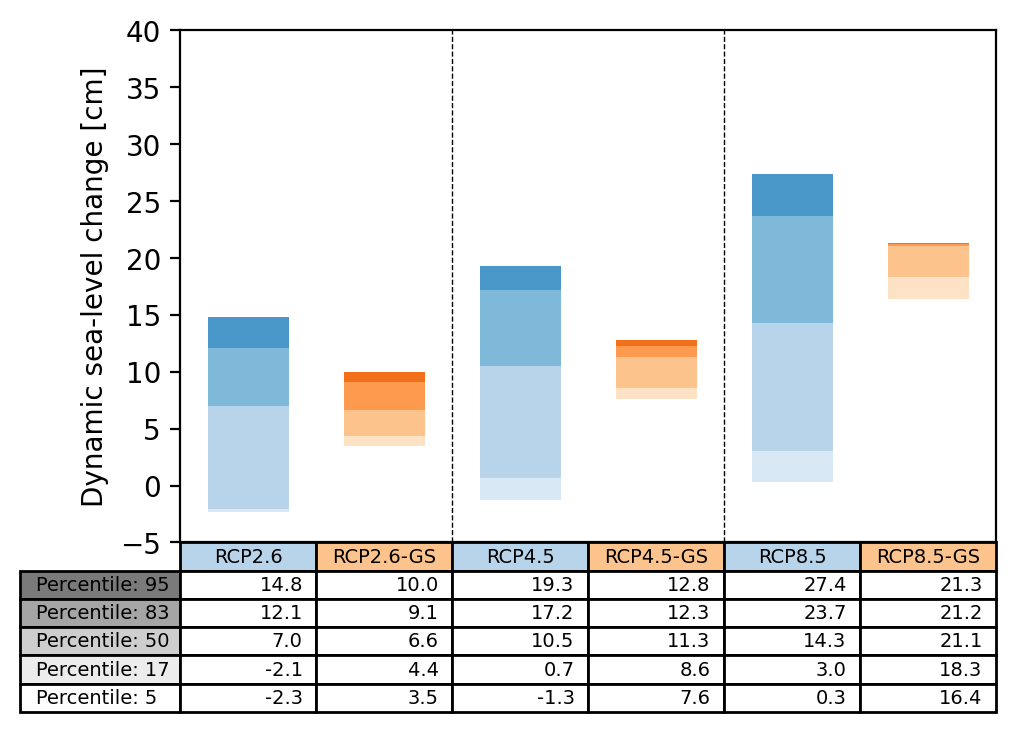

In [100]:
plot_barplots(Bar_ds5, ['RCP2.6', 'RCP2.6-GS', 'RCP4.5', 'RCP4.5-GS', 'RCP8.5', 'RCP8.5-GS'] , 'MLD', 'MLD', saveplots=None)

In [51]:
def plot_barplots(pandadf, new_col_names, varx_ch, comparison, saveplots=None):
    
    pandadf = pandadf.reindex(columns = new_col_names)

    fig, ax = plt.subplots(1,dpi=100)
    ax = summary_fig_and_table(ax, pandadf, colors='alternate', vlines=True)
    ax.set_ylabel('Dynamic sea-level change [cm]');

    plt.subplots_adjust(left=0.22, bottom=0.24)
    if saveplots==True:
        plt.savefig(savepath+f'Barplot_{varx_ch}_{comparison}.png')

In [52]:
def edit_scen_name(sce):
    '''Convert name from rcp85 to RCP8.5 and ssp585 to SSP5-8.5'''
    

    if 'rcp' in sce:
        sce_out = f'{sce[0:3].upper()}{sce[3]}.{sce[4]}'
    elif 'ssp' in sce:
        sce_out = f'{sce[0:3].upper()}{sce[3]}-{sce[4]}.{sce[5]}'
    else:
        print('Scenario name not recognised')
    return sce_out

def make_barplot(ds, mip, mods_list, perc, start_year, end_year):
    
    # Create Data Frame 
    
    col = [f'{mip.upper()} Scenario']
    for p in perc:
        col.append(f'Percentile: {p}')    
    summary_df = pd.DataFrame(columns=col)
    
    sces = ['ssp126','ssp245','ssp585']
    
    if mip == 'cmip5':
        sces_m = ['rcp26','rcp45','rcp85']
    elif mip == 'cmip6':
        sces_m = sces
    
    for idx,sce in enumerate(sces):
        
        # Check models:
        #print(mods_list[i])
        ds_mods = ds.sel(time=slice(1900,2100), scenario=sce, model=mods_list[idx])#select_models(ds.sel(time=slice(1900,2100),scenario=sce), 'GSAT','GSAT','zos','model')[1]
        print(f'# of models for {sce}, {mip}: {len(ds_mods.model.values)}')
        # Calculate zos, GSAT for time of interest:
        zos = ds_mods.sel(time=slice(start_year, end_year)).mean(dim='time').zos
        #GSAT = ds_mods.sel(time=slice(start_year, end_year)).mean(dim='time').GSAT

        # Append the percentile scores to a list val
        val = [edit_scen_name(sces_m[idx])]
        for p in perc:
            val.append(round(np.quantile(zos.values,p/100),1))
        summary_df.loc[idx] = val
    
    
    summary_df.set_index(col[0], inplace=True)
    summary_df = summary_df.T
        
    return summary_df

In [53]:
def summary_fig_and_table(ax, df, colors=None, vlines=False):
    
    mi = 0.6 # Max color intensity
    
    # Get some pastel shades for the colors
    if not(colors):
        colors = plt.cm.Oranges(np.linspace(0, mi, len(df.index)))
        rowColours = colors
        
        # Expand the array
        ones = np.ones(len(df.columns))
        colors = colors[np.newaxis,:,:] * ones[:, np.newaxis, np.newaxis]
        
    elif colors=='alternate':
        colors1 = plt.cm.Oranges(np.linspace(0, mi, len(df.index)))
        colors2 = plt.cm.Blues(np.linspace(0, mi, len(df.index)))
        colors = np.zeros([len(df.columns), len(df.index), 4])
        colors[::2] = colors2
        colors[1::2] = colors1
        
        rowColours = plt.cm.Greys(np.linspace(0, mi, len(df.index)))

    # Start from white color
    colors[:,0,:] = 0
    
    index = np.arange(len(df.columns))
    bar_width = 0.6

    # Initialize the vertical-offset for the stacked bar chart.
    y_offset = np.zeros(len(df.columns))

    # Plot bars and create text labels for the table
    cell_text = []
    for row in range(len(df.index)):
        ax.bar(index, 
               df.iloc[row]-y_offset, 
               bar_width, 
               bottom=y_offset, 
               color=colors[:,row,:])
        
        y_offset = df.iloc[row]
        cell_text.append(['%1.1f' % x for x in df.iloc[row]])
    
    ax.set_xlim(-0.5,index[-1]+0.5)
    ax.set_ylim(-5,40)
    
    # Add a table at the bottom of the axes
    ax.table(cellText=cell_text[::-1],
             rowLabels=df.index[::-1],
             rowColours=rowColours[::-1],
             colColours=colors[:,2,:],
             colLabels=df.columns,
             loc='bottom')

    ax.set_xticks([])
    
    if vlines:
        xcoords = index[0:]+1.5
        xcoords = xcoords[::2]
        for xc in xcoords:
            plt.axvline(x=xc, color='black', linewidth=0.5, linestyle='--')
    
    return ax